#### library

In [3]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

code_directory = os.path.abspath('../code')  # 상위 디렉토리로 가서 b 디렉토리 경로
sys.path.append(code_directory)

from features import *
from preprocessing_fn import *
from preprocessing import *

from sklearn.neighbors import KDTree
from sklearn.metrics import mean_absolute_error

from utils.constant_utils import Directory
from utils import common_utils
import preprocessing
import preprocessing_fn

import model
from inference import *

#### data load

In [12]:
# file load

# train & test & submission load
data_path = "~/data"
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# plus_info load
interest_data = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_data = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_data = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_data = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

In [13]:
print(train_data.shape, test_data.shape)
train_data.head(3)

(1801228, 11) (150172, 10)


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0


#### test

In [11]:
print("Start the main.py successfully!")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

# 클러스터 피처 apply
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=15)

# 이상치 처리
print("start to cleaning outliers...")
df = preprocessing_fn.handle_outliers(df)

train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)

# 중복 제거
print("start to preprocessing...")
train_data_ = preprocessing_fn.handle_duplicates(train_data_)
valid_data_ = preprocessing_fn.handle_duplicates(valid_data_)

# 전처리 적용
train_data_ = preprocessing.time_feature_preprocessing(train_data_)
valid_data_ = preprocessing.time_feature_preprocessing(valid_data_)
test_data_ = preprocessing.time_feature_preprocessing(test_data_)

# 새로운 피처 추가
print("start to feature engineering...")
train_data_, valid_data_, test_data_ = create_nearest_subway_distance(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_subway_within_radius(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_nearest_park_distance_and_area(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_school_within_radius(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_place_within_radius(train_data_, valid_data_, test_data_)

# 정규화
train_data_, valid_data_, test_data_ = preprocessing_fn.standardization(train_data_, valid_data_, test_data_)

# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing_fn.feature_selection(train_data_, valid_data_, test_data_)

# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

# train model
print("Train the model")
model_ = model.xgboost(X_train, y_train)

prediction, mae = inference(model_, 'validation', X_valid, y_valid)
print("mae : ", mae)

# train with total dataset
print("Train with total dataset")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

Start the main.py successfully!
start to cleaning outliers...
start to preprocessing...
start to feature engineering...
Train the model
mae :  4544.124324666189
Train with total dataset


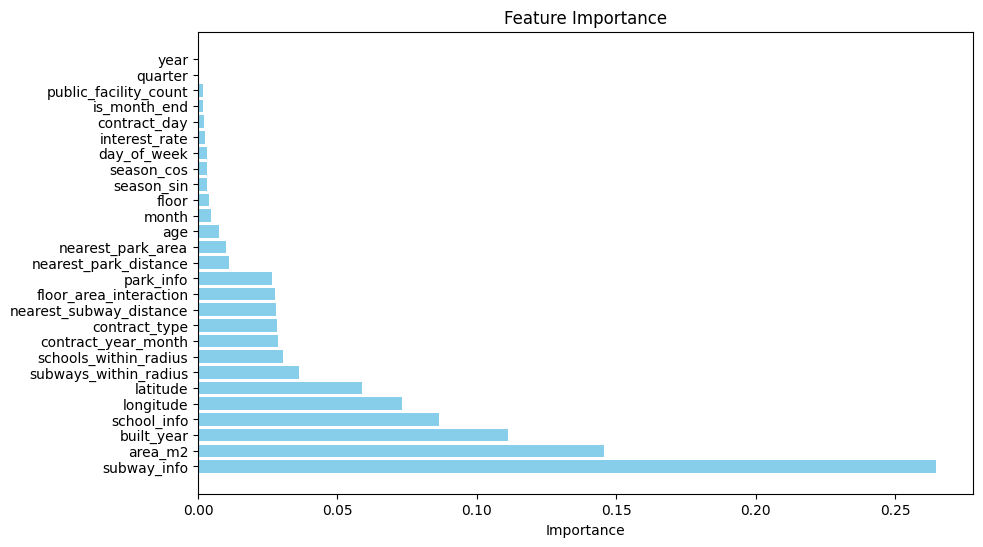

In [12]:
# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

#### feature engineering

In [14]:
train_df = train_data.copy()
new_df = time_feature_preprocessing(train_df)

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 21 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   index                   int64         
 1   area_m2                 float64       
 2   contract_year_month     int64         
 3   contract_day            int64         
 4   contract_type           int64         
 5   floor                   int64         
 6   built_year              int64         
 7   latitude                float64       
 8   longitude               float64       
 9   age                     int64         
 10  deposit                 float64       
 11  year                    int64         
 12  month                   int64         
 13  date                    datetime64[ns]
 14  day_of_week             int32         
 15  quarter                 int32         
 16  is_month_end            int64         
 17  season                  object        
 18  se

In [16]:
new_df

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,year,month,date,day_of_week,quarter,is_month_end,season,season_sin,season_cos,floor_area_interaction
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,2019,6,2019-06-25,1,2,0,Summer,1.000000e+00,6.123234e-17,764.9829
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,2020,3,2020-03-26,3,1,0,Spring,0.000000e+00,1.000000e+00,1699.9620
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,2020,3,2020-03-28,5,1,0,Spring,0.000000e+00,1.000000e+00,679.9848
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,2019,7,2019-07-15,0,3,0,Summer,1.000000e+00,6.123234e-17,59.3400
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,2019,4,2019-04-12,4,2,0,Spring,0.000000e+00,1.000000e+00,358.8600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,2023,11,2023-11-25,5,4,0,Fall,1.224647e-16,-1.000000e+00,574.0630
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,2023,11,2023-11-28,1,4,0,Fall,1.224647e-16,-1.000000e+00,611.4528
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,2023,12,2023-12-03,6,4,0,Winter,-1.000000e+00,-1.836970e-16,2181.0100
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,2023,12,2023-12-04,0,4,0,Winter,-1.000000e+00,-1.836970e-16,1528.6320


#### 범주화

In [25]:
### floor
new_df['floor'].value_counts()

floor
 4     119287
 5     118429
 3     115059
 2     110110
 6     107313
        ...  
 66         2
 64         1
-4          1
 67         1
-3          1
Name: count, Length: 73, dtype: int64

In [31]:
new_df['floor'].sort_values(ascending=False)

array([ 9, 20,  8, ..., 19, 15, 10])

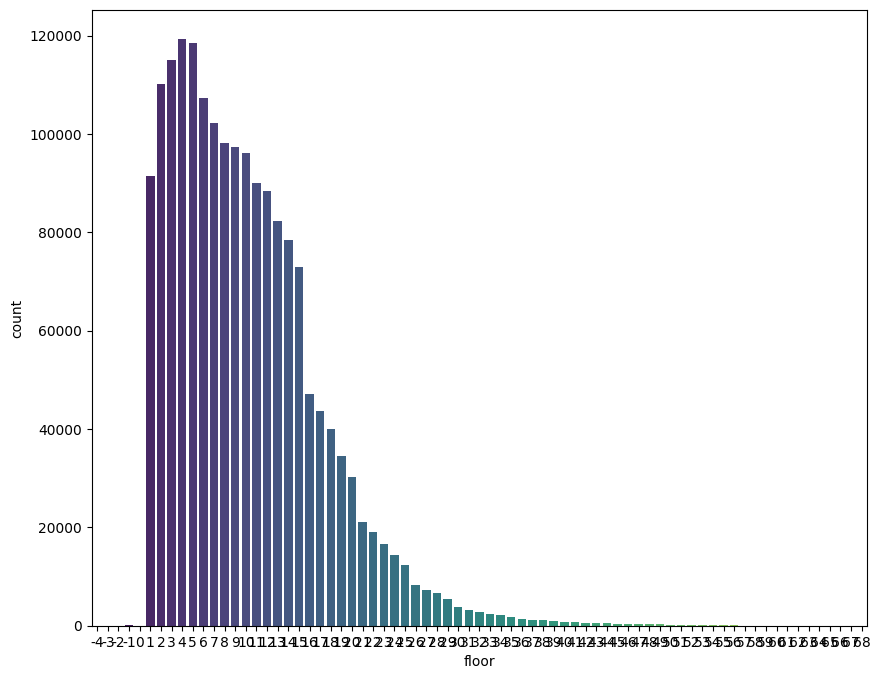

In [33]:
plt.figure(figsize=(10, 8))
sns.countplot(data=new_df, x='floor', order=sorted(new_df['floor'].unique()), palette='viridis')
plt.show()

##### 공공시설 개수

In [9]:
location_data = train_data[['longitude','latitude']].copy()
print("전체 지역 데이터 수 : ", location_data.shape[0])
unique_location_df = location_data.drop_duplicates().reset_index(drop=True)
print("unique한 지역 데이터 수 : ", unique_location_df.shape[0])
unique_location_df

전체 지역 데이터 수 :  1801228
unique한 지역 데이터 수 :  18491


,longitude,latitude
0,127.045216,37.054314
1,127.055847,36.964647
2,127.084514,36.972390
3,127.048779,36.965423
4,127.047449,36.957089
...,...,...
18486,126.657868,37.612604
18487,126.716550,37.584117
18488,126.716193,37.582593
18489,126.706269,37.581261


In [22]:
### seoul park 측정
seoul_area_parks = park_data[(park_data['latitude'] >= 37.0) & (park_data['latitude'] <= 38.0) &
                                (park_data['longitude'] >= 126.0) & (park_data['longitude'] <= 128.0)]
### seoul school 측정
seoul_area_school = school_data[(school_data['latitude'] >= 37.0) & (school_data['latitude'] <= 38.0) &
                                (school_data['longitude'] >= 126.0) & (school_data['longitude'] <= 128.0)]
### seoul subway 측정
seoul_area_subway = subway_data[(subway_data['latitude'] >= 37.0) & (subway_data['latitude'] <= 38.0) &
                                (subway_data['longitude'] >= 126.0) & (subway_data['longitude'] <= 128.0)]

In [29]:
# 공공시설을 count하는 함수 (haversine 사용)
def count_nearby_facilities(train_row, facility_data, radius):
    count = 0
    train_coords = (train_row['latitude'], train_row['longitude'])
    
    # 모든 시설을 돌면서 거리 계산
    for _, facility_row in facility_data.iterrows():
        facility_coords = (facility_row['latitude'], facility_row['longitude'])
        distance = haversine(train_coords, facility_coords, unit=Unit.KILOMETERS)
        
        if distance <= radius:
            count += 1
            
    return count

In [30]:
# train_data에 새로운 feature 추가
def add_public_facility_feature(train_data, subway_data, park_data, school_data, radius):
    facility_counts = []
    
    # tqdm을 적용하여 train_data의 진행 상황을 표시
    for _, train_row in tqdm(train_data.iterrows(), total=len(train_data), desc="Processing train data"):
        # 각각의 공공시설의 반경 내 개수를 계산
        subway_count = count_nearby_facilities(train_row, subway_data, radius)
        park_count = count_nearby_facilities(train_row, park_data, radius)
        school_count = count_nearby_facilities(train_row, school_data, radius)
        
        # 총 공공시설 개수를 합산
        total_count = subway_count + park_count + school_count
        facility_counts.append(total_count)
    
    # 새로운 feature를 train_data에 추가
    train_data['주변 공공시설 개수'] = facility_counts
    return train_data

In [ ]:
train_data_with_facility_count = add_public_facility_feature(unique_location_df, seoul_area_parks, seoul_area_school, seoul_area_subway, radius = 0.02)
train_data_with_facility_count
# 너무 오래걸림..

In [9]:
print("Start the main.py successfully!")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

# 클러스터 피처 apply
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=15)

# 이상치 처리
print("start to cleaning outliers...")
df = preprocessing_fn.handle_outliers(df)

train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)

# 중복 제거
print("start to preprocessing...")
train_data_ = preprocessing_fn.handle_duplicates(train_data_)
valid_data_ = preprocessing_fn.handle_duplicates(valid_data_)

# 전처리 적용
train_data_ = preprocessing.time_feature_preprocessing(train_data_)
valid_data_ = preprocessing.time_feature_preprocessing(valid_data_)
test_data_ = preprocessing.time_feature_preprocessing(test_data_)

# feature engineering
print("start to feature engineering...")
train_data_, valid_data_, test_data_ = create_place_within_radius(train_data_, valid_data_, test_data_)


Start the main.py successfully!
start to cleaning outliers...
start to preprocessing...
start to feature engineering...


In [10]:
train_data_['public_facility_count']

0          3
1          3
2          3
3          0
4          0
          ..
1801183    0
1801184    0
1801185    0
1801186    0
1801187    0
Name: public_facility_count, Length: 1518975, dtype: int64

#### 최종 데이터셋 정의

1. day 변수 삭제, age 삭제
2. 범주화 진행(floor, type 등)
3. 시설 개수